Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.1


In [ ]:
pip install tensorflow==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/skin_cancer_dataset/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/skin_cancer_dataset/Test/")
data_dir_train

PosixPath('/content/gdrive/My Drive/skin_cancer_dataset/Train')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2240 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2240 files belonging to 9 classes.
Using 448 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

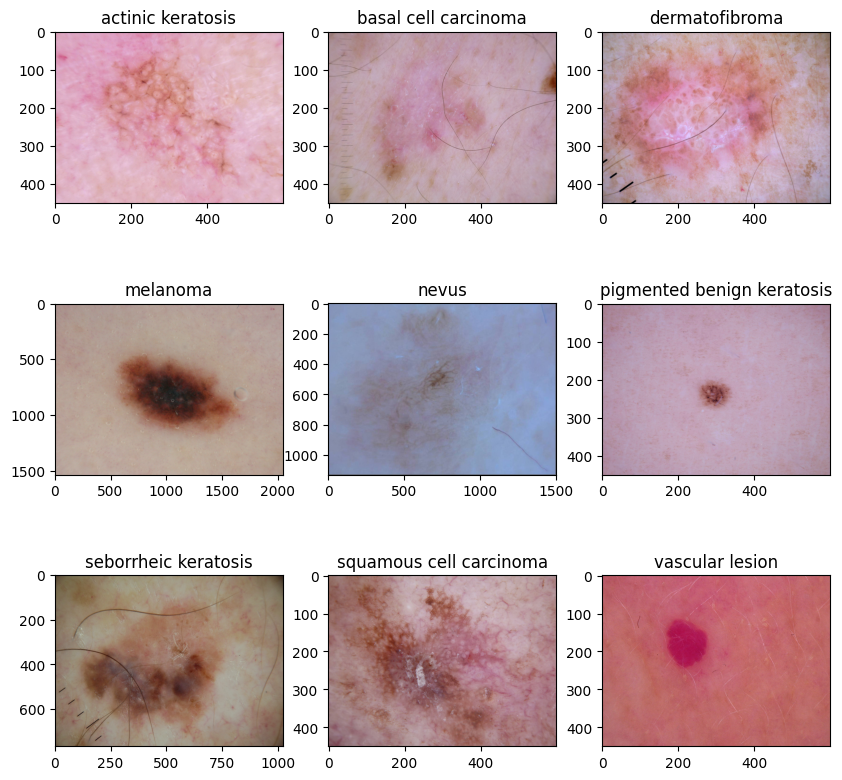

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 116s 711ms/step - loss: 2.0496 - accuracy: 0.2087 - val_loss: 1.9163 - val_accuracy: 0.3080
Epoch 2/20
56/56 [==============================] - 23s 403ms/step - loss: 1.9413 - accuracy: 0.2723 - val_loss: 1.8387 - val_accuracy: 0.3281
Epoch 3/20
56/56 [==============================] - 23s 414ms/step - loss: 1.8231 - accuracy: 0.3320 - val_loss: 1.6904 - val_accuracy: 0.4196
Epoch 4/20
56/56 [==============================] - 22s 400ms/step - loss: 1.7002 - accuracy: 0.3783 - val_loss: 1.6022 - val_accuracy: 0.4174
Epoch 5/20
56/56 [==============================] - 23s 412ms/step - loss: 1.6183 - accuracy: 0.4308 - val_loss: 1.5601 - val_accuracy: 0.4397
Epoch 6/20
56/56 [==============================] - 22s 401ms/step - loss: 1.5181 - accuracy: 0.4699 - val_loss: 1.5906 - val_accuracy: 0.4263
Epoch 7/20
56/56 [==============================] - 23s 412ms/step - loss: 1.4987 - accuracy: 0.4738 - val_loss: 1.4293 - val_accuracy: 0.522

### Visualizing training results

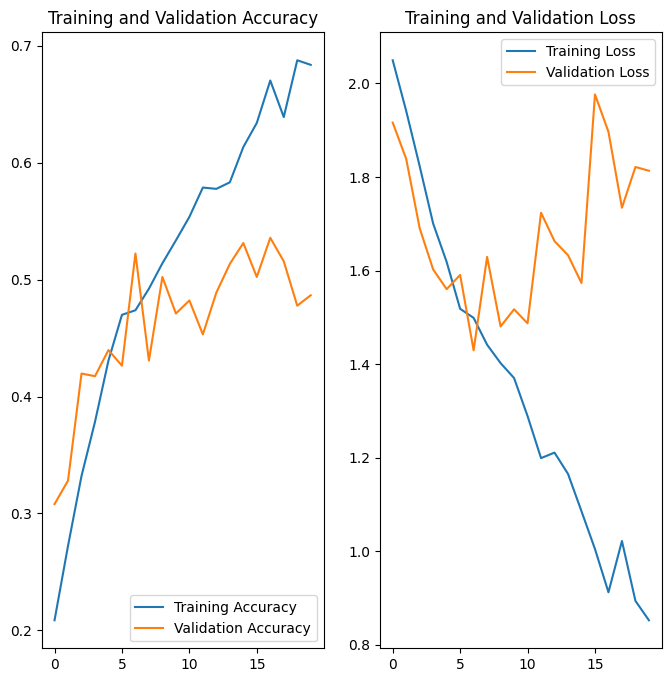

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The above accuracy plot shows training accuracy is increasing especially after 10th epoch whereas validation shows gradual increment. This shows the model is overfitting.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


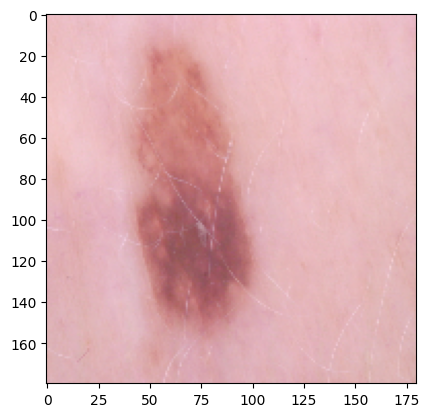

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augmentation1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_ds))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

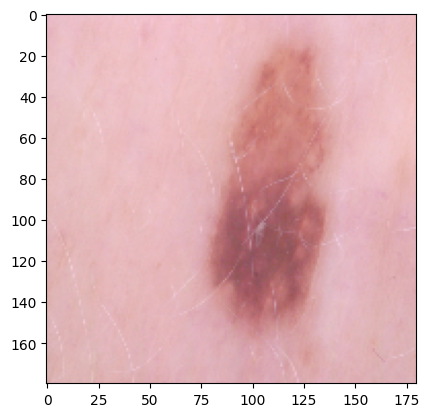

In [ ]:
plt.imshow(data_augmentation1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 522ms/step - loss: 2.0643 - accuracy: 0.2215 - val_loss: 2.0129 - val_accuracy: 0.2054
Epoch 2/20
56/56 [==============================] - 29s 520ms/step - loss: 1.9421 - accuracy: 0.2902 - val_loss: 1.8573 - val_accuracy: 0.3348
Epoch 3/20
56/56 [==============================] - 29s 520ms/step - loss: 1.7998 - accuracy: 0.3594 - val_loss: 1.9704 - val_accuracy: 0.3438
Epoch 4/20
56/56 [==============================] - 29s 521ms/step - loss: 1.6800 - accuracy: 0.3968 - val_loss: 1.6724 - val_accuracy: 0.3884
Epoch 5/20
56/56 [==============================] - 29s 520ms/step - loss: 1.6366 - accuracy: 0.4202 - val_loss: 1.7587 - val_accuracy: 0.3683
Epoch 6/20
56/56 [==============================] - 29s 521ms/step - loss: 1.6194 - accuracy: 0.4129 - val_loss: 1.6096 - val_accuracy: 0.4464
Epoch 7/20
56/56 [==============================] - 29s 516ms/step - loss: 1.6154 - accuracy: 0.4191 - val_loss: 1.6496 - val_accuracy: 0.4621

### Visualizing the results

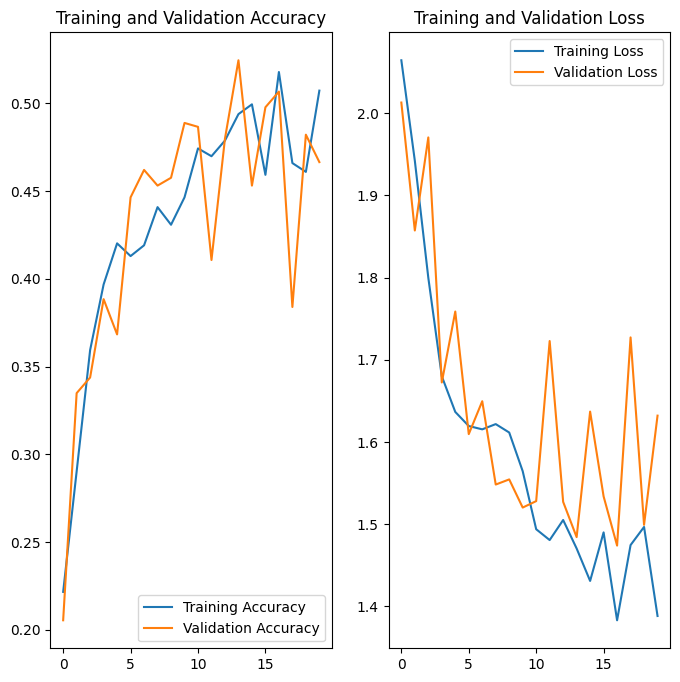

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Issue of overfitting has been fixed to some extent after augmenation is introduced.
However accuracy is not upto the mark and still can be improved further.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,squamous cell carcinoma,181
2,vascular lesion,140
3,actinic keratosis,114
4,basal cell carcinoma,376
5,nevus,357
6,melanoma,438
7,pigmented benign keratosis,462
8,seborrheic keratosis,77


<Axes: xlabel='No. of Image', ylabel='Class'>

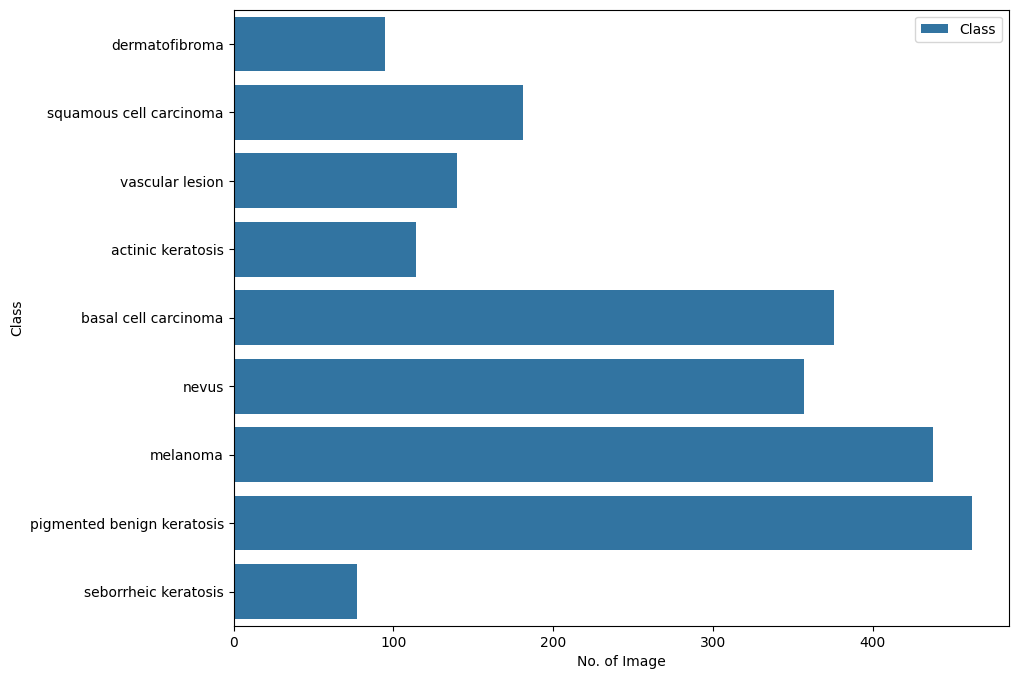

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? - seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? - pigmented benign keratosis'


In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/skin_cancer_dataset/T...,actinic keratosis
1,/content/gdrive/My Drive/skin_cancer_dataset/T...,actinic keratosis
2,/content/gdrive/My Drive/skin_cancer_dataset/T...,actinic keratosis
3,/content/gdrive/My Drive/skin_cancer_dataset/T...,actinic keratosis
4,/content/gdrive/My Drive/skin_cancer_dataset/T...,actinic keratosis
...,...,...
2235,/content/gdrive/My Drive/skin_cancer_dataset/T...,vascular lesion
2236,/content/gdrive/My Drive/skin_cancer_dataset/T...,vascular lesion
2237,/content/gdrive/My Drive/skin_cancer_dataset/T...,vascular lesion
2238,/content/gdrive/My Drive/skin_cancer_dataset/T...,vascular lesion


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='/content/gdrive/My Drive/skin_cancer_dataset/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78501C723970>: 100%|██████████| 500/500 [00:04<00:00, 110.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78501C721E40>: 100%|██████████| 500/500 [00:04<00:00, 114.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785040FA3C10>: 100%|██████████| 500/500 [00:04<00:00, 114.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=961x649 at 0x78501C7072B0>: 100%|██████████| 500/500 [00:14<00:00, 33.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78504017EB00>: 100%|██████████| 500/500 [00:12<00:00, 39.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78501C7E6EF0>: 100%|██████████| 500/500 [00:04<00:00, 107.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78501C7BC4C0>: 100%|██████████| 500/500 [00:06<00:00, 74.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785040FBFE80>: 100%|██████████| 500/500 [00:04<00:00, 105.69 Samples/s]


Initialised with 140 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7850401DF940>: 100%|██████████| 500/500 [00:04<00:00, 111.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,640
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
augmented_data_dir = data_dir_train
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 1348 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
##
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 28s 484ms/step - loss: 2.0685 - accuracy: 0.1869 - val_loss: 2.0324 - val_accuracy: 0.1562
Epoch 2/30
56/56 [==============================] - 27s 485ms/step - loss: 1.9582 - accuracy: 0.2539 - val_loss: 1.8379 - val_accuracy: 0.3214
Epoch 3/30
56/56 [==============================] - 27s 487ms/step - loss: 2.0078 - accuracy: 0.2254 - val_loss: 2.0111 - val_accuracy: 0.2679
Epoch 4/30
56/56 [==============================] - 27s 487ms/step - loss: 2.0246 - accuracy: 0.1858 - val_loss: 2.0481 - val_accuracy: 0.1875
Epoch 5/30
56/56 [==============================] - 27s 492ms/step - loss: 2.0003 - accuracy: 0.2232 - val_loss: 1.9791 - val_accuracy: 0.2835
Epoch 6/30
56/56 [==============================] - 27s 487ms/step - loss: 1.8821 - accuracy: 0.3058 - val_loss: 1.8523 - val_accuracy: 0.3616
Epoch 7/30
56/56 [==============================] - 27s 482ms/step - loss: 1.8006 - accuracy: 0.3410 - val_loss: 1.8775 - val_accuracy: 0.3348

#### **Todo:**  Visualize the model results

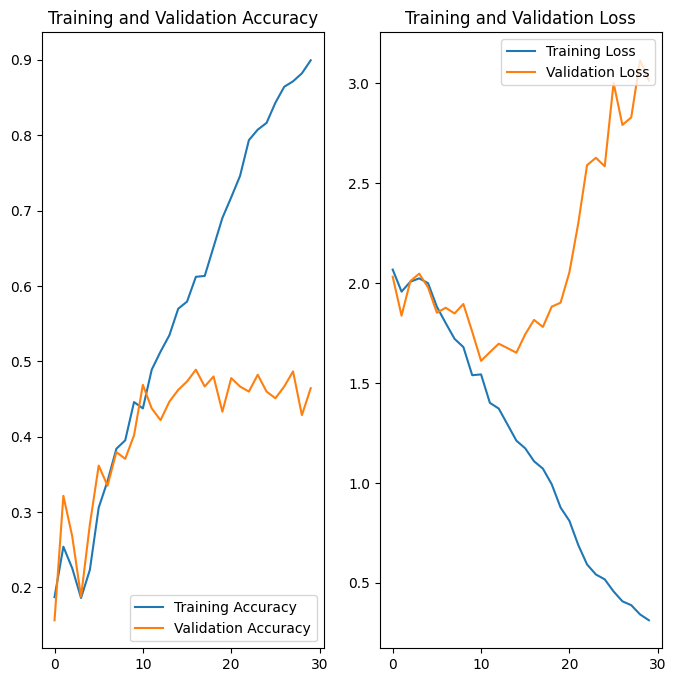

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Though accuracy is significantly increased, overfitting
still remains the same. Performance can be further improved by hyper parameter tuning and trying out with different loss functions
